In [69]:
#Import Required Libraries

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import itertools
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector, r, IntVector
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
import gc

#ARIMA and Time Series
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

#ARFIMA from ARCH package
from arch.univariate import ARX
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera
from scipy.stats import chi2
from scipy.stats import norm

#*** Haven't Chosen Which Ones Yet ***

In [17]:
#Importing the headline CPI
df = pd.read_csv('/Users/nitaycarmi/Desktop/URSS Project/Datasets/Consumer Price Index All Items Total for United Kingdom .csv', parse_dates=['observation_date'])
df.rename(columns={'observation_date': 'Date', 'GBRCPALTT01IXNBM': 'CPI Headline'}, inplace=True)

In [19]:
print(df.head())
print(df.info())

        Date  CPI Headline
0 1960-01-01      5.611997
1 1960-02-01      5.611997
2 1960-03-01      5.601784
3 1960-04-01      5.632423
4 1960-05-01      5.632423
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          767 non-null    datetime64[ns]
 1   CPI Headline  767 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.1 KB
None


In [21]:
#Checking for missing values in Headline CPI
df.set_index('Date', inplace=True)
print(df.isna().sum())

CPI Headline    0
dtype: int64


In [23]:
# Seasonally adjusted data
resultH = seasonal_decompose(df['CPI Headline'], model='additive', period=12)
df['CPI_seasonally_adjusted'] = df['CPI Headline'] - resultH.seasonal

In [25]:
# Stationarity Check ADF - CPI Headline
adf_resultH = adfuller(df['CPI Headline'])
print(f'ADF Statistic: {adf_resultH[0]}')
print(f'p-value: {adf_resultH[1]}')

ADF Statistic: 1.4831431701228384
p-value: 0.9974609718715096


In [27]:
# Stationarity Check KPSS - CPI Headline
kpss_stat, p_value, lags, critical_values = kpss(df['CPI Headline'], regression='c', nlags='auto')
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Number of lags: {lags}')
print(f'Critical values: {critical_values}')

KPSS Statistic: 4.352747554219699
p-value: 0.01
Number of lags: 17
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_1214/3153560118.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(df['CPI Headline'], regression='c', nlags='auto')


In [29]:
# Make sure the index is datetime — this is safe even if it already is
df.index = pd.to_datetime(df.index)

start_date = '1970-02-01'
end_date = '2023-11-01'

df_filtered = df.loc[start_date:end_date]

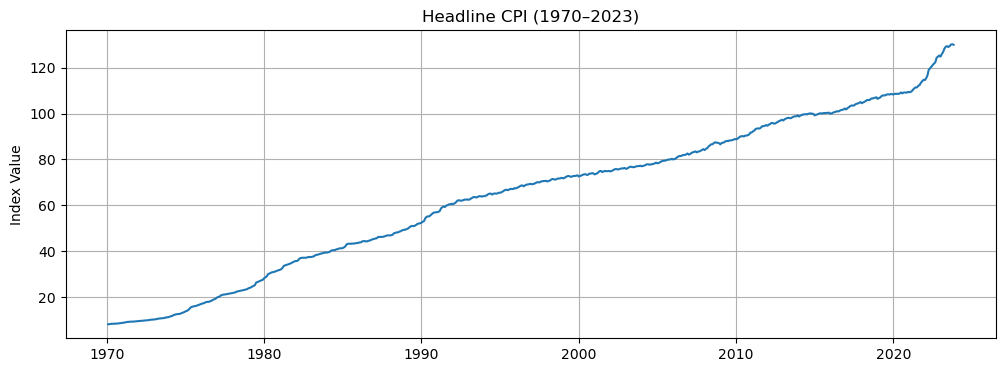

In [31]:
# Headline CPI
plt.figure(figsize=(12, 4))
plt.plot(df_filtered.index, df_filtered['CPI Headline'], label='Headline CPI')
plt.title('Headline CPI (1970–2023)')
plt.ylabel('Index Value')
plt.grid(True)
plt.show()

In [33]:
# Take the first difference and check for unit root again
df['CPI_Headline_diff'] = df['CPI Headline'].diff().dropna()
print("Headline Differenced:", adfuller(df['CPI_Headline_diff'].dropna())[1])

Headline Differenced: 0.00030343801243113284


In [35]:
# Stationarity Test - KPSS CPI Headline 1st Difference
series = df['CPI_Headline_diff'].dropna()
kpss_stat, p_value, lags, critical_values = kpss(series, regression='c', nlags='auto')
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Number of lags: {lags}')
print(f'Critical values: {critical_values}')

KPSS Statistic: 0.8714878528946634
p-value: 0.01
Number of lags: 13
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_1214/205353213.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(series, regression='c', nlags='auto')


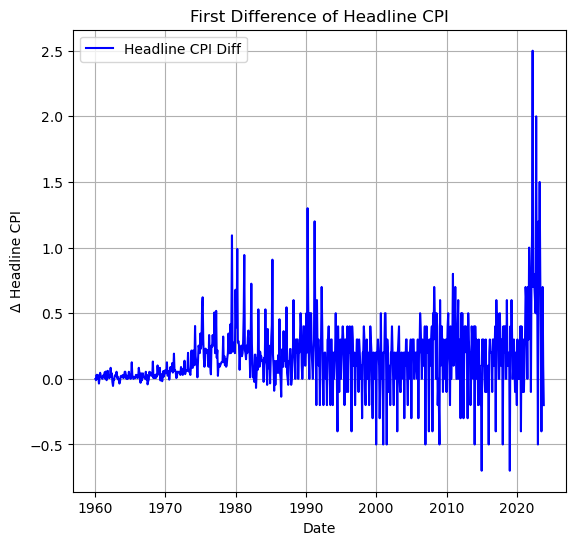

In [38]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(df['CPI_Headline_diff'], color='blue', label='Headline CPI Diff')
plt.title('First Difference of Headline CPI')
plt.xlabel('Date')
plt.ylabel('Δ Headline CPI')
plt.grid(True)
plt.legend()

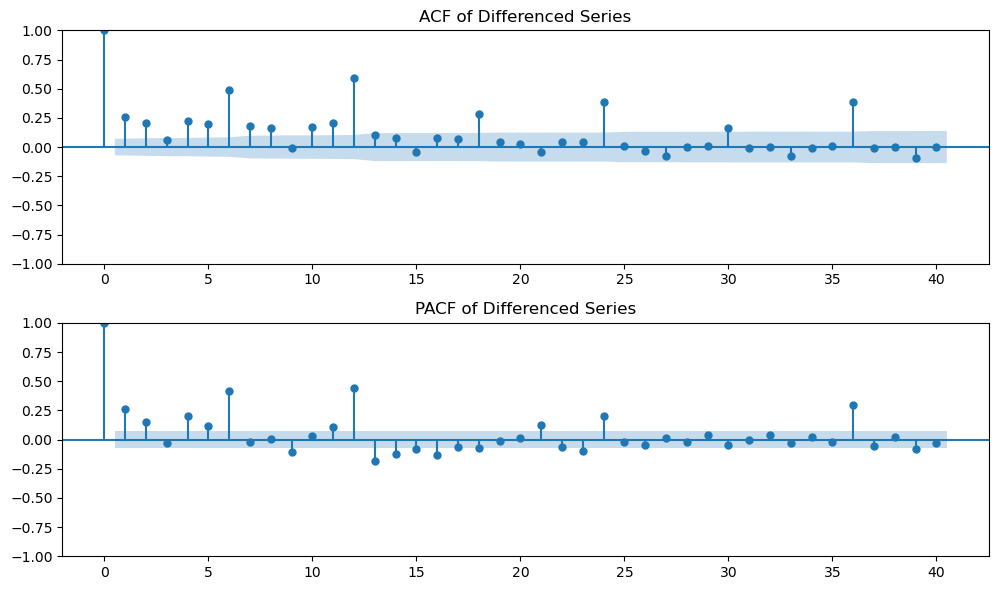

In [40]:
#Plot the ACF and PACF for the first difference of the Headline Inflation
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(df['CPI_Headline_diff'].dropna(), ax=ax[0], lags=40)
plot_pacf(df['CPI_Headline_diff'].dropna(), ax=ax[1], lags=40)

ax[0].set_title('ACF of Differenced Series')
ax[1].set_title('PACF of Differenced Series')

plt.tight_layout()
plt.show()

In [42]:
print(df['CPI_Headline_diff'].isna().sum())

1


In [44]:
series_filled = df['CPI_Headline_diff'].fillna(method='ffill')
series_no_nan = df['CPI_Headline_diff'].dropna()

/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_1214/1747236464.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_filled = df['CPI_Headline_diff'].fillna(method='ffill')


In [48]:
model = pm.auto_arima(
    series_no_nan,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=1,
    seasonal=True,
    stepwise=True,
    max_step=10,  # limit stepwise search steps
    suppress_warnings=True,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=444.470, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=259.583, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28.500, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=442.471, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28.461, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=30.415, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-35.860, Time=1.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=28.487, Time=0.89 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-42.643, Time=1.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-63.249, Time=1.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-7.417, Time=1.37 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-55.555, Time=2.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-70.732, Time=1.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-22.352, Time=1.89 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-73.440, T

In [52]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  766
Model:               SARIMAX(3, 1, 4)   Log Likelihood                 111.066
Date:                Sun, 10 Aug 2025   AIC                           -206.132
Time:                        13:09:06   BIC                           -169.013
Sample:                    02-01-1960   HQIC                          -191.843
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0037      0.006     -0.629      0.530      -0.015       0.008
ar.L2          0.0030      0.006      0.500      0.617      -0.009       0.015
ar.L3         -0.9932      0.005   -191.464      0.0

#### Validation of (3, 1, 4) as the optimal ARIMA Model for CPI Headline

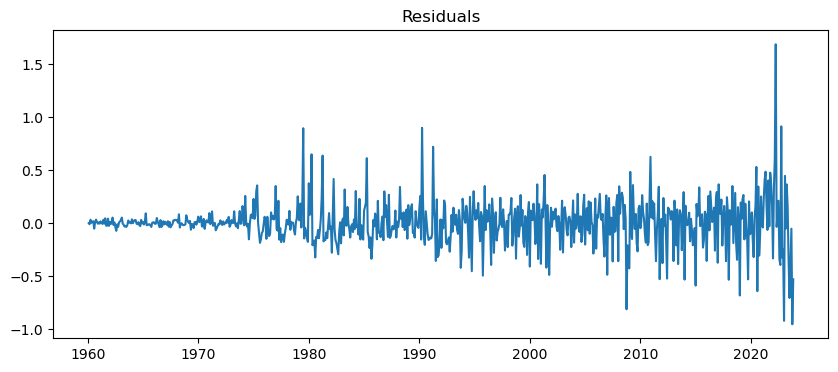

In [55]:
#1.Check Residuals
residuals = model.resid()
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

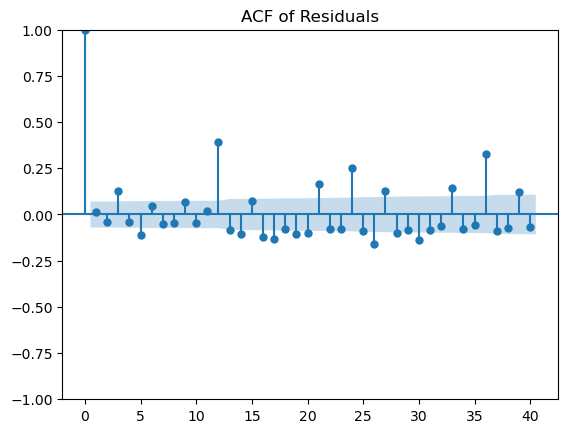

In [57]:
#2. ACF of Residuals
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()

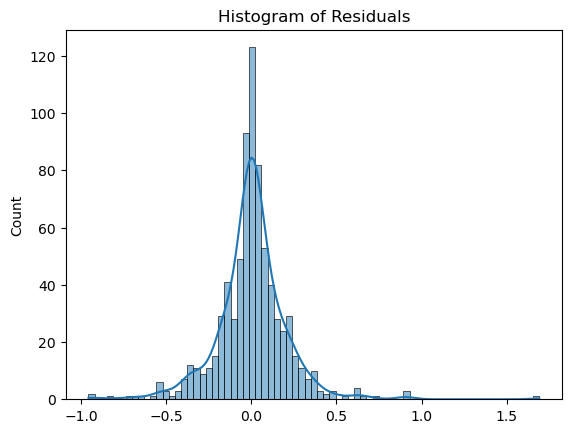

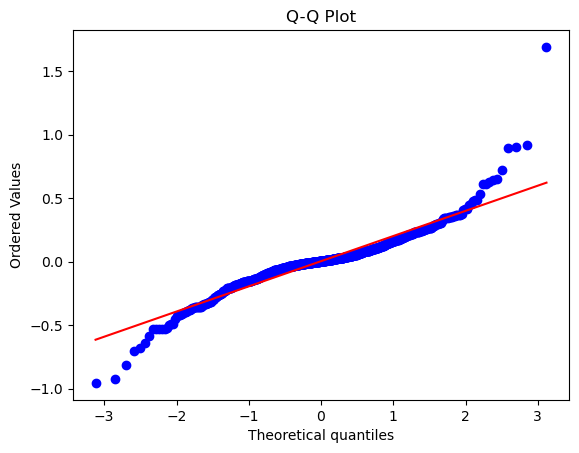

In [59]:
#3. Check Residual Normality
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [61]:
#4. Ljung Box Test (Autocorrelation Test)
ljung_box = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box)

      lb_stat  lb_pvalue
10  35.836571    0.00009


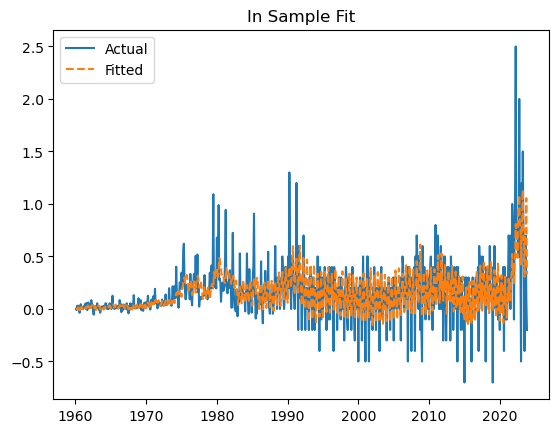

In [63]:
#5. In Sample Predictions
fitted_vals = model.predict_in_sample()
plt.plot(df['CPI_Headline_diff'].dropna(), label='Actual')
plt.plot(fitted_vals, label='Fitted', linestyle='--')
plt.legend()
plt.title('In Sample Fit')
plt.show()

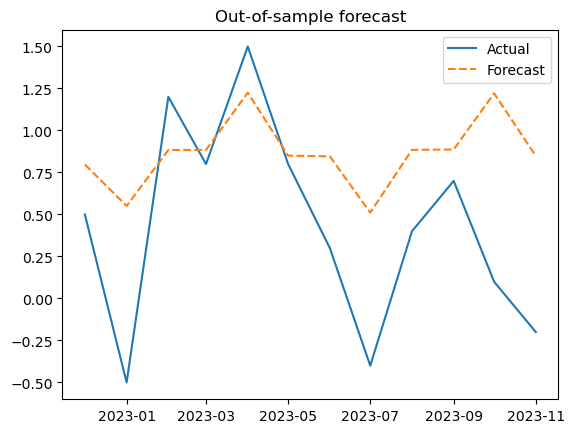

In [71]:
#6. Out of Sample Forecast
n_test = 12
train = df['CPI_Headline_diff'].dropna()[:-n_test]
test = df['CPI_Headline_diff'].dropna()[-n_test:]

gc.collect()
model = pm.auto_arima(train, d=1, seasonal=False, stepwise=True)

forecast = model.predict(n_periods=n_test)

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title('Out-of-sample forecast')
plt.show()

In [73]:
#Root Mean Squared Error to Verify Underfitting
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.6539


In [75]:
#Mean Absolute Percentage Error
mape = np.mean(np.abs((test - forecast) / test)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 211.16%


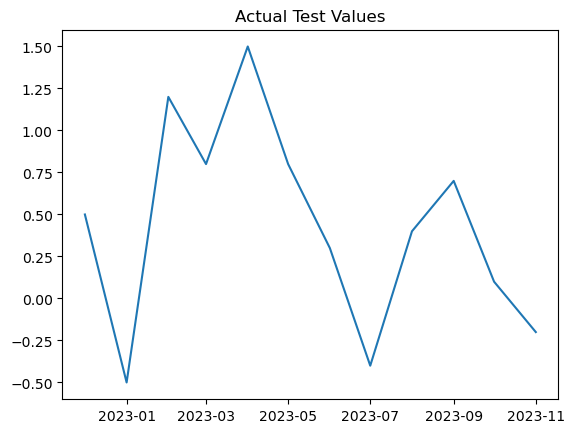

In [77]:
plt.plot(test)
plt.title("Actual Test Values")
plt.show()

In [79]:
#Try and check for MAE and RMSE to see if the ARIMA 
mae = mean_absolute_error(test, forecast)
print(f"MAE: {mae:.4f}")

naive_forecast = train.iloc[-1]
naive_forecst_series = [naive_forecast] * len(test)
naive_rmse = np.sqrt(mean_squared_error(test, naive_forecst_series))
print(f"Naive RMSE: {naive_rmse:.4f}")

MAE: 0.5310
Naive RMSE: 0.5930


In [81]:
# Define parameter grid
p = q = range(0, 4)
d = [1]
pdq = list(itertools.product(p, d, q))

# Initialize
best_score = float("inf")
best_cfg = None

# Grid search
for param in pdq:
    try:
        model = ARIMA(train, order=param)
        results = model.fit()

        # Forecast the same number of steps as test set
        pred = results.forecast(steps=len(test))

        # Align prediction shape and drop NaNs if needed
        pred = pred[:len(test)].dropna()
        actual = test[:len(pred)]

        # RMSE calculation
        rmse = np.sqrt(mean_squared_error(actual, pred))

        # Track best model
        if rmse < best_score:
            best_score, best_cfg = rmse, param

        print(f"ARIMA{param} RMSE={rmse:.4f}")
        
    except Exception as e:
        print(f"ARIMA{param} failed: {e}")
        continue

print(f"\n✅ Best ARIMA{best_cfg} RMSE={best_score:.4f}")

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be use

ARIMA(0, 1, 0) RMSE=0.5930
ARIMA(0, 1, 1) RMSE=0.6881
ARIMA(0, 1, 2) RMSE=0.6841


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 3) RMSE=0.6963
ARIMA(1, 1, 0) RMSE=0.8067
ARIMA(1, 1, 1) RMSE=0.6843


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be use

ARIMA(1, 1, 2) RMSE=0.6881


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 3) RMSE=0.6269
ARIMA(2, 1, 0) RMSE=0.8257


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be use

ARIMA(2, 1, 1) RMSE=0.6899


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) RMSE=0.6378


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 3) RMSE=0.8575
ARIMA(3, 1, 0) RMSE=0.7435


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be use

ARIMA(3, 1, 1) RMSE=0.6879


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converg

ARIMA(3, 1, 2) RMSE=0.6624
ARIMA(3, 1, 3) RMSE=0.7778

✅ Best ARIMA(0, 1, 0) RMSE=0.5930


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


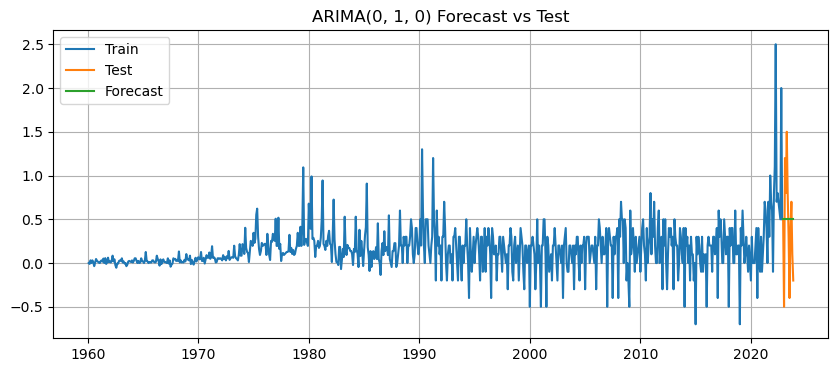

In [83]:
model = ARIMA(train, order=(0,1,0))
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.title('ARIMA(0, 1, 0) Forecast vs Test')
plt.grid()
plt.show()

In [85]:
naive_pred = np.repeat(train.iloc[-1], len(test))
naive_rmse = np.sqrt(mean_squared_error(test, naive_pred))
print(f"Naive RMSE: {naive_rmse:.4f}")

Naive RMSE: 0.5930


### Overall, ARIMA model is not a very good explanatory model to forecast inflation